In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import seaborn as sns
import numpy as np
import ast
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import statsmodels.api as sm

matplotlib.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Model
- YOLOv5 XL
- YOLOv5 confidence 0.75
- Optimizer: Adam
- Batch size: 256
- ResNet50V2
- GlobalAveragePooling2D
- Dense layer(s): 4096 x 2048 units
- Dropout rate: 0.2
- Dilation: 5px
- Max Epochs: 130
- Early Stopping Patience: 10 epochs
- Minimum YOLOv5 bounding box pixel area: 8,911 (> 1st percentile)
- Minimum training images per class: 0 (0th pct)
     - Total classes: 574

In [2]:
path = '/Users/josephking/Documents/sponsored_projects/MERGEN/output/MakeModelClassifier/2021-11-30-22h08/logs'
df = pd.read_csv(os.path.join(path, 'predictions.csv'))
ovr_conf_mat = pd.read_csv(os.path.join(path, 'OVR Confusion Matrix.csv')).rename(columns={'Unnamed: 0': 'Make-Model'})

## OVR Confusion Matrix

#### Count of images per Make-Model class in test set

In [3]:
counts = df.groupby('true_label')['Acura RSX'].count().reset_index().rename(columns={'Acura RSX': 'count', 'true_label': 'Make-Model'})

In [4]:
counts['count'].describe()

count    574.000000
mean      53.787456
std       58.067964
min       10.000000
25%       18.000000
50%       34.000000
75%       68.000000
max      542.000000
Name: count, dtype: float64

In [5]:
ovr_conf_mat = ovr_conf_mat.merge(counts, how='left')

In [6]:
ovr_conf_mat = ovr_conf_mat.sort_values(by=['F1'], ascending=False).reset_index(drop=True)
ovr_conf_mat

,Make-Model,TP,FN,FP,TN,Accuracy,Precision,Recall_Sensitivity_TPR,FNR,FPR,Specificity_TNR,F1,count
0,Jeep Renegade,35,0,2,30837,0.9999,0.9459,1.0000,0.0000,0.0001,0.9999,0.9722,35
1,Mercedes-Benz G-Class,104,1,7,30762,0.9997,0.9369,0.9905,0.0095,0.0002,0.9998,0.9630,105
2,Ford E-Series,195,8,11,30660,0.9994,0.9466,0.9606,0.0394,0.0004,0.9996,0.9535,203
3,Jeep Wrangler,126,6,8,30734,0.9995,0.9403,0.9545,0.0455,0.0003,0.9997,0.9474,132
4,Cadillac XT6,9,1,0,30864,1.0000,1.0000,0.9000,0.1000,0.0000,1.0000,0.9474,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,Jaguar XE,3,14,8,30849,0.9993,0.2727,0.1765,0.8235,0.0003,0.9997,0.2143,17
570,Scion iA,1,9,0,30864,0.9997,1.0000,0.1000,0.9000,0.0000,1.0000,0.1818,10
571,Chevrolet Classic,1,9,1,30863,0.9997,0.5000,0.1000,0.9000,0.0000,1.0000,0.1667,10
572,Chevrolet C/K,1,10,2,30861,0.9996,0.3333,0.0909,0.9091,0.0001,0.9999,0.1429,11


# Make-Model sorted best to worst by F1 statistic

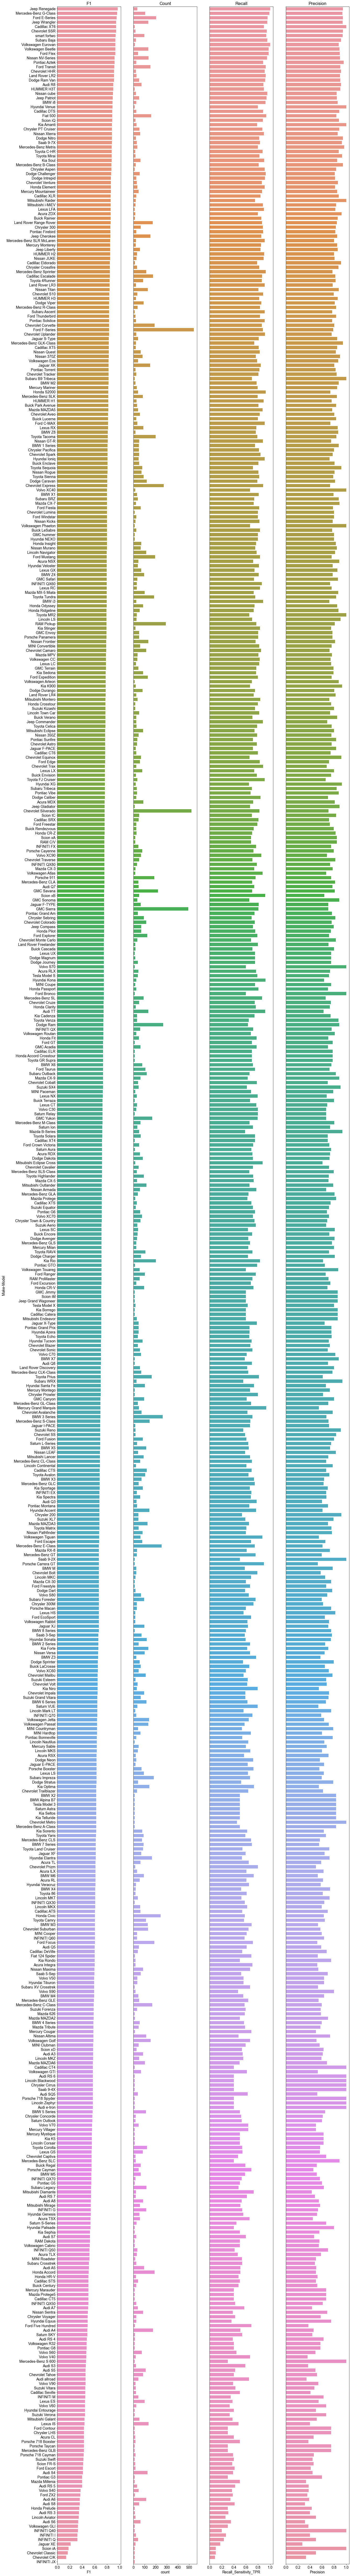

In [7]:
plt.close()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 180), sharey=True)
sns.set(font_scale=1.2)
sns.barplot(data=ovr_conf_mat, x='F1', y='Make-Model', ax=ax1)
ax1.title.set_text('F1')
sns.barplot(data=ovr_conf_mat, x='count', y='Make-Model', ax=ax2)
ax2.title.set_text('Count')
ax2.axes.get_yaxis().set_visible(False)
sns.barplot(data=ovr_conf_mat, x='Recall_Sensitivity_TPR', y='Make-Model', ax=ax3)
ax3.title.set_text('Recall')
ax3.axes.get_yaxis().set_visible(False)
sns.barplot(data=ovr_conf_mat, x='Precision', y='Make-Model', ax=ax4)
ax4.title.set_text('Precision')
ax4.axes.get_yaxis().set_visible(False)
plt.show()

# Predictors of F1 score in test set

In [8]:
# Image directory dataframe
df = pd.read_csv('../data/Bboxes.csv',
                usecols=['Make', 'Model', 'Category', 'Source Path', 'Bboxes'])
df['Bboxes'] = df['Bboxes'].apply(lambda x: list(ast.literal_eval(x)))
df = df.loc[df.Bboxes.str.len() != 0].reset_index(drop=True)  # restrict to rows with bounding boxes


# Bbox image size in pixel area]
min_bbox_area = 3731
area = df['Bboxes'].apply(lambda x: (x[3] - x[1]) * (x[2] - x[0])).astype(int)  # Format: xyxy
df = df.loc[area >= min_bbox_area].reset_index(drop=True)

# Make-Model
df['Make-Model'] = df['Make'] + ' ' + df['Model']

In [9]:
df.head()

,Make,Model,Category,Source Path,Bboxes,Make-Model
0,Acura,CL,Car,Acura/CL/2001/f04ed53e11.jpg,"[3.0, 56.0, 252.0, 138.0, 0.88232421875]",Acura CL
1,Acura,CL,Car,Acura/CL/2001/6084dddd71.jpg,"[3.0, 54.0, 248.0, 157.0, 0.859375]",Acura CL
2,Acura,CL,Car,Acura/CL/2001/723a443ab2.jpg,"[16.0, 48.0, 239.0, 152.0, 0.931640625]",Acura CL
3,Acura,CL,Car,Acura/CL/2001/cb6d1e23cb.jpg,"[29.0, 152.0, 1787.0, 920.0, 0.89453125]",Acura CL
4,Acura,CL,Car,Acura/CL/2001/ede0361fca.jpg,"[37.0, 60.0, 254.0, 139.0, 0.9306640625]",Acura CL


#### Number of total images

In [10]:
img_count = df.groupby('Make-Model')['Source Path'].count().reset_index().rename(columns={'Source Path': 'Img Count'})
img_count['Img Count^2'] = img_count['Img Count'] ** 2

#### Number of total years vehicle make observed

In [11]:
df['Year'] = df['Source Path'].apply(lambda x: x.split('/')[2])
df['MinYear'] = df.groupby('Make-Model')['Year'].transform(min).astype(int)
df['MaxYear'] = df.groupby('Make-Model')['Year'].transform(max).astype(int)
df['TotalYears'] = (df['MaxYear'] - df['MinYear']) + 1

#### Average number of images per make-model-year

In [12]:
df['Img Count MMY'] = df.groupby(['Make-Model', 'Year'])['Source Path'].transform('count')
df['Avg Img Count MMY'] = df.groupby('Make-Model')['Img Count MMY'].transform('mean').astype(int)

#### Merge onto ORV confusion matrix dataframe

In [13]:
df = df[['Make-Model', 'Category', 'Make', 'TotalYears', 'Avg Img Count MMY']].drop_duplicates(subset=['Make-Model']).reset_index(drop=True)

In [14]:
subset = ovr_conf_mat[['Make-Model', 'F1', 'count']].copy()
subset.rename(columns={'count': 'Test Count'}, inplace=True)
subset['Test Count^2'] = subset['Test Count'] ** 2

conf_mat = subset.merge(df, on='Make-Model', how='left')
conf_mat.rename(columns={'count': 'Test Count'}, inplace=True)

conf_mat = conf_mat.merge(img_count, on='Make-Model', how='left')

#### Convert vehicle category and vehicle make to onehot

In [15]:
conf_mat = pd.concat([conf_mat, pd.get_dummies(conf_mat['Category'], drop_first=True)], axis=1)
del conf_mat['Category']

conf_mat = pd.concat([conf_mat, pd.get_dummies(conf_mat['Make'], drop_first=True)], axis=1)
del conf_mat['Make']

conf_mat = conf_mat.set_index('Make-Model')

### Multivate OLS regression

In [16]:
y = conf_mat['F1']
X = conf_mat.iloc[:, 1:]
X.drop(columns=['Test Count^2', 'Img Count^2'], inplace=True)  # these covariates are extremely highly collinear

### Differences in F1 score, excluding dummies for vehicle make

In [17]:
model = sm.OLS(y, sm.add_constant(X.iloc[:, :7])).fit(cov_type='HC0', use_t=True)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     F1   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     14.79
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           9.20e-18
Time:                        09:01:32   Log-Likelihood:                 354.99
No. Observations:                 574   AIC:                            -694.0
Df Residuals:                     566   BIC:                            -659.2
Df Model:                           7                                         
Covariance Type:                  HC0                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.6709      0.02

### Differences in F1 score by vehicle make, not conditioning on other factors

In [18]:
model = sm.OLS(y, sm.add_constant(X.iloc[:, 7:])).fit(cov_type='HC0', use_t=True)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     F1   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     79.06
Date:                Wed, 01 Dec 2021   Prob (F-statistic):          4.16e-195
Time:                        09:01:32   Log-Likelihood:                 375.27
No. Observations:                 574   AIC:                            -670.5
Df Residuals:                     534   BIC:                            -496.4
Df Model:                          39                                         
Covariance Type:                  HC0                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6492      0.032     20.029

### Differences in F1 score, full model

In [19]:
model = sm.OLS(y, sm.add_constant(X.iloc[:, :])).fit(cov_type='HC0', use_t=True)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     F1   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     70.04
Date:                Wed, 01 Dec 2021   Prob (F-statistic):          4.46e-194
Time:                        09:01:32   Log-Likelihood:                 407.08
No. Observations:                 574   AIC:                            -720.2
Df Residuals:                     527   BIC:                            -515.6
Df Model:                          46                                         
Covariance Type:                  HC0                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.6613      0.03